Demonstrates comparing results between BasiCO, libRoadRunner, and SimBio. 

Credit to Frank Bergmann for contributing to development of the simulator API and providing a BasiCO implementation, 
and to Hernan Grecco and Mauro Silber for providing a SimBio implementation. 

Requires biomodels, copasi-basico[ssr], libroadrunner, simbio[io], and matplotlib.

In [ ]:
import biomodels
import libsbml
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import poincare.solvers
from roadrunner import RoadRunner
from simbio import Simulator
import simbio.io.sbml
from typing import Dict, List, Union

import libssr
from libssr.SSRSimAPI import SSRSimAPI

rng = np.random.default_rng(0)

# BasiCO Simulator Interface Implementation

In [2]:
from basico.ssr.CopasiSSR import CopasiSSR

# RoadRunner Simulator Interface Implementation

In [3]:
class RoadRunnerSSR(SSRSimAPI):

    def __init__(self):
        self.rr = None

    def load_model(self, *args, **kwargs):
        self.rr = RoadRunner(*args)

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        if isinstance(sample_info, int):
            sample_size = sample_info
            do_sampling = False
        else:
            sample_size = len(sample_info)
            do_sampling = True

        results = {n: np.ndarray((sample_size, len(times)), dtype=float) for n in names}
        for i in range(sample_size):
            self.rr.resetAll()
            if do_sampling:
                for n, v in sample_info[i].items():
                    self.rr[n] = v
            res = self.rr.simulate(times=times)
            for n in names:
                results[n][i, :] = res[f'[{n}]']
        return results

# SimBio Simulator Interface Implementation

In [4]:
class SimBioSSR(SSRSimAPI):
    def load_model(self, simulator: Simulator, solver, /, *args, **kwargs):
        self.simulator = simulator
        self.solver = solver
        return self

    def produce_results(
        self,
        names: list[str],
        times: list[float] | np.ndarray,
        sample_info: int | list[dict[str, float]],
    ) -> dict[str, np.ndarray]:
        if isinstance(sample_info, int):
            d = {}
            sample_size = sample_info
            sample_values = (d for _ in range(sample_size))
        else:
            sample_size = len(sample_info)
            sample_values = [{getattr(self.simulator.model, k): v for k, v in e.items()} for e in sample_info]

        times = np.asarray(times)
        results = {name: np.empty((sample_size, times.size)) for name in names}
        for i, values in enumerate(sample_values):
            df = self.simulator.solve(values=values, save_at=times, solver=self.solver)
            for n in names:
                results[n][i] = df[n]

        return results

## Prep Simulators

In [ ]:
# Get model from BioModels

model_normal_fun = RoadRunner.getParamPromotedSBML(biomodels.get_omex('BIOMD10').master.read_text())
doc = libsbml.readSBMLFromString(model_normal_fun)
model_names = [s.getId() for s in doc.getModel().getListOfSpecies()]
time_final = 6000.0
num_steps = 100
sample_size = 10000
sig_figs = 12

expl_sample_info = {'J0_n': rng.uniform(0.9, 1.1, size=sample_size)}

In [ ]:
# Prevent copasi from using names
for el in doc.getModel().getListOfSpecies():
    el.setName(el.getId())
model_normal_fun = libsbml.writeSBMLToString(doc)

In [7]:
sims = []
sim_labels = []
sim_expl_sample = []

In [8]:
sim_cp = CopasiSSR()
sim_cp.load_model(model_normal_fun)
sims.append(sim_cp)
sim_labels.append('BasiCO')
sim_expl_sample.append(pd.DataFrame({'J0_n': expl_sample_info['J0_n']}).to_dict("records"))

In [9]:
sim_rr = RoadRunnerSSR()
sim_rr.load_model(model_normal_fun)
sims.append(sim_rr)
sim_labels.append('RoadRunner')
sim_expl_sample.append(pd.DataFrame({'J0_n': expl_sample_info['J0_n']}).to_dict("records"))

In [10]:
sim_sb = SimBioSSR()
simbio_model = simbio.io.sbml.loads(model_normal_fun, name='MAPK')
sim_sb.load_model(Simulator(simbio_model, backend='numba'),
                  poincare.solvers.LSODA(rtol=1E-9, atol=1E-9))

sims.append(sim_sb)
sim_labels.append('SimBio')
sim_expl_sample.append(pd.DataFrame({'J0_n': expl_sample_info['J0_n']}).to_dict("records"))

# Generate Samples

In [11]:
results_times = np.linspace(0., time_final, num_steps)
results = [{k: libssr.round_arr_to_sigfigs(v, sig_figs) 
            for k, v in sim.produce_results(model_names, results_times, sample_size if sinfo is None else sinfo).items()} 
           for sim, sinfo in zip(sims, sim_expl_sample)]

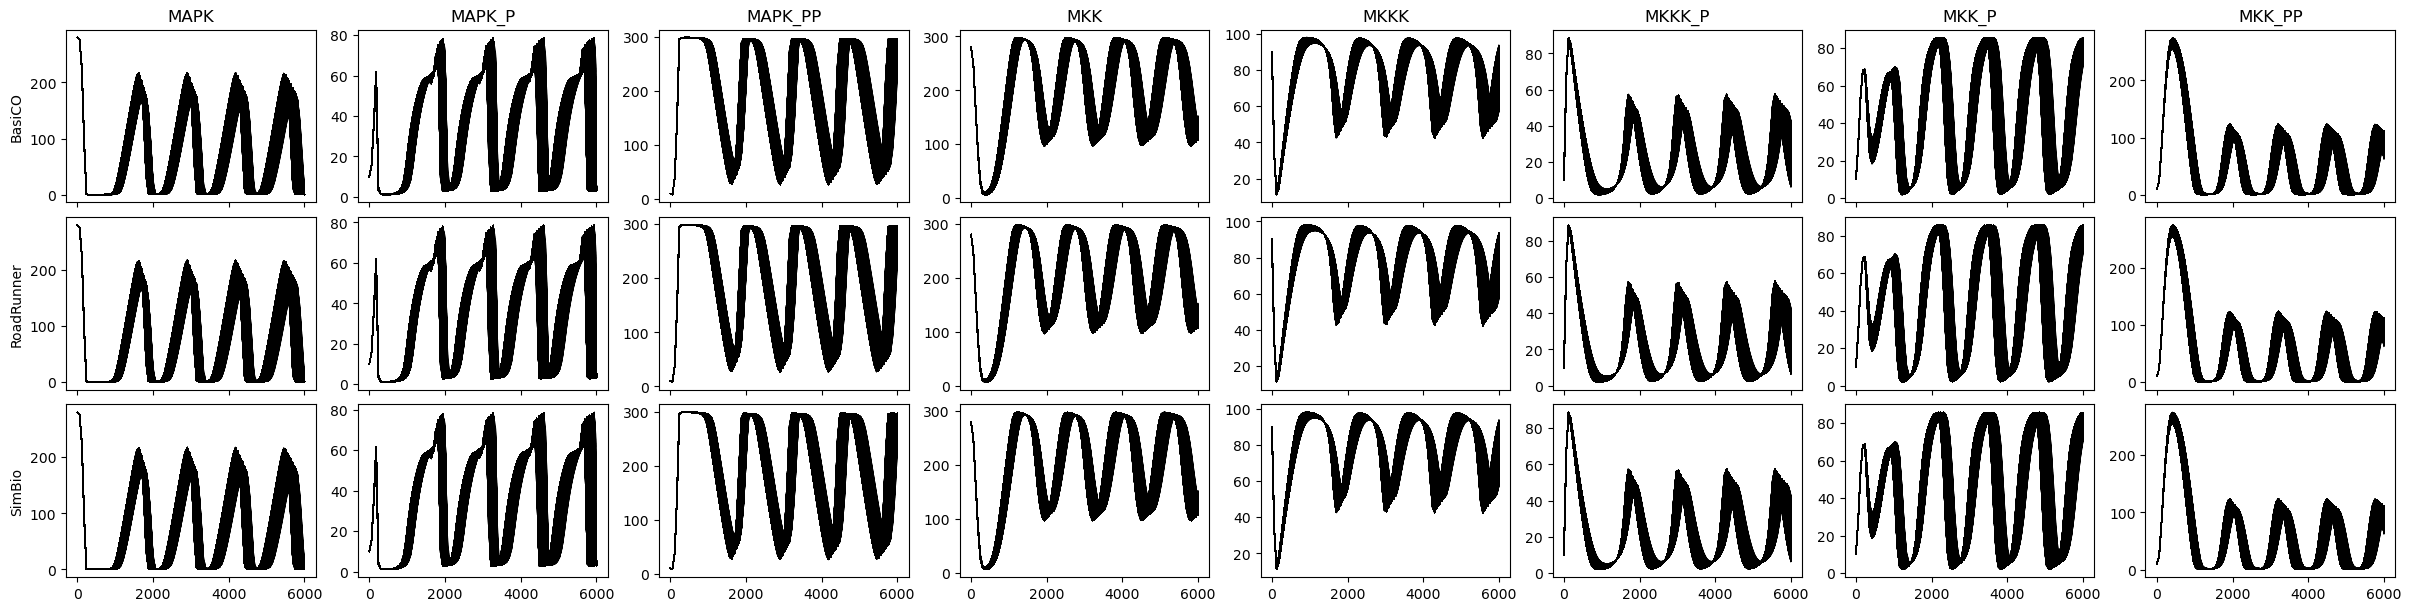

In [12]:
fig, axs = plt.subplots(len(results), len(model_names), layout='compressed', 
                        figsize=(3 * len(model_names), 2 * len(results)), sharex=True, sharey='col')

for i in range(sample_size):
    for j, n in enumerate(model_names):
        for k, r in enumerate(results):
            axs[k][j].plot(results_times, r[n][i, :], alpha=0.002, color='black')
for i in range(len(sim_labels)):
    axs[i][0].set_ylabel(sim_labels[i])
for i in range(len(model_names)):
    axs[0][i].set_title(model_names[i])

## Show Normalization to Help Spot Any Differences

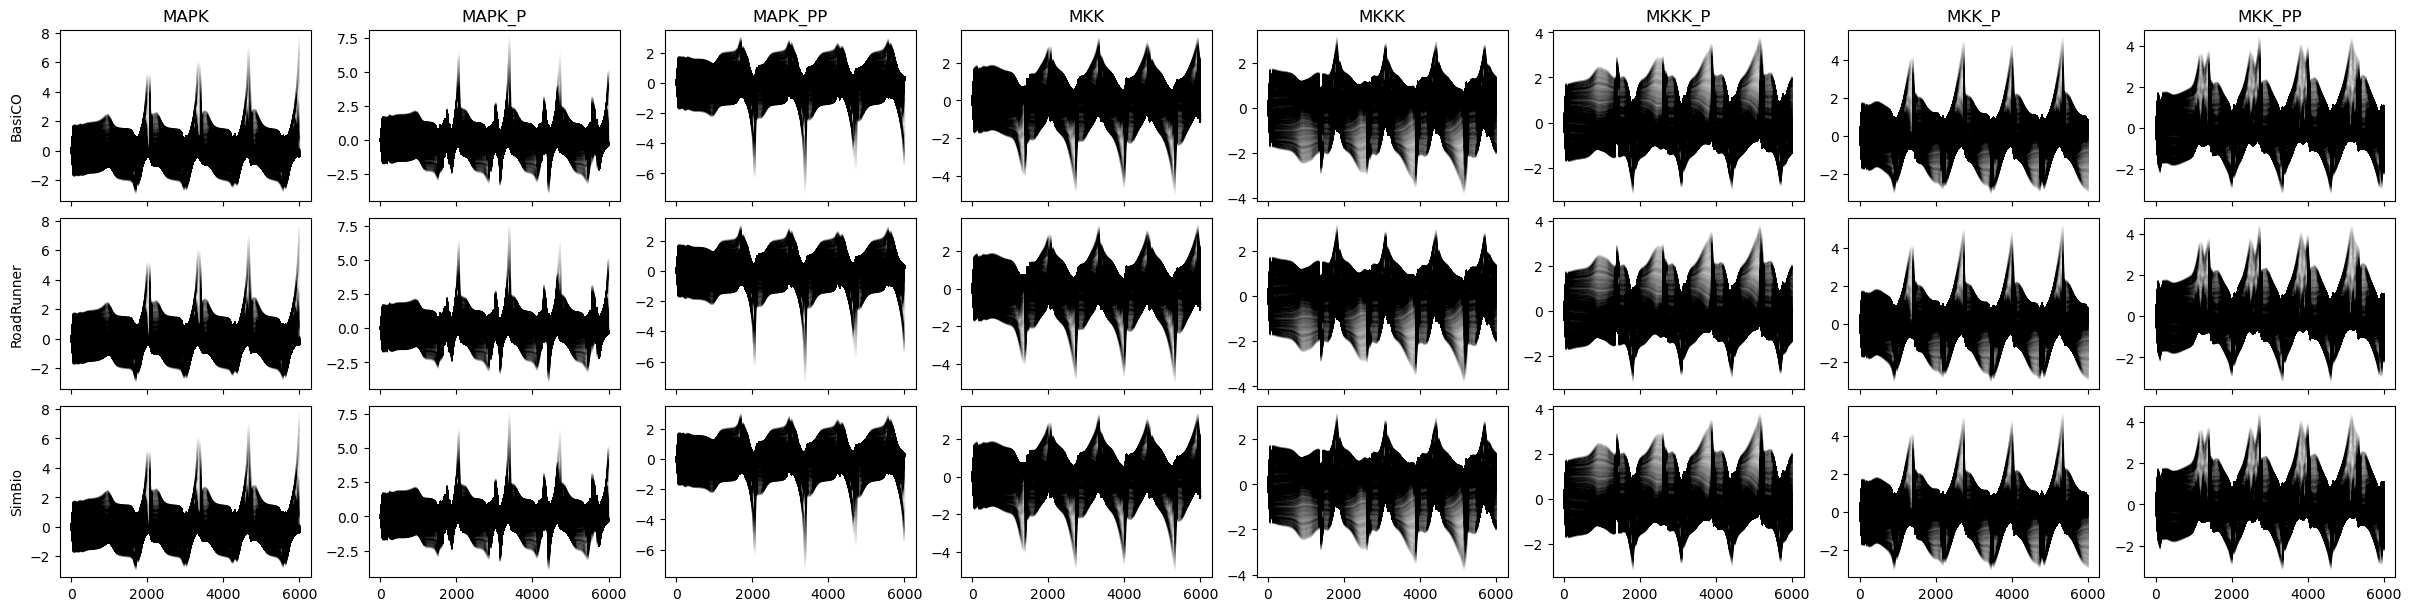

In [13]:
fig, axs = plt.subplots(len(results), len(model_names), layout='compressed', 
                        figsize=(3 * len(model_names), 2 * len(results)), sharex=True, sharey='col')

results_norm = []
for r in results:
    rd = {}
    for k, v in r.items():
        v_std = np.std(v, axis=0)
        mask = v_std != 0
        vm = v[:, mask]
        rdv = np.array(v)
        rdv[:, mask] = (vm - np.mean(vm, axis=0)[None, :]) / v_std[mask][None, :]
        rdv[:, ~mask] = 0
        rd[k] = rdv
    results_norm.append(rd)

for i in range(sample_size):
    for j, n in enumerate(model_names):
        for k, r in enumerate(results_norm):
            axs[k][j].plot(results_times, r[n][i, :], alpha=0.002, color='black')
for i in range(len(sim_labels)):
    axs[i][0].set_ylabel(sim_labels[i])
for i in range(len(model_names)):
    axs[0][i].set_title(model_names[i])

# Test Reproducibility

In [ ]:
err_samples = [libssr.sample_efect_error(res, err_thresh=1E-3)[0] for res in results]

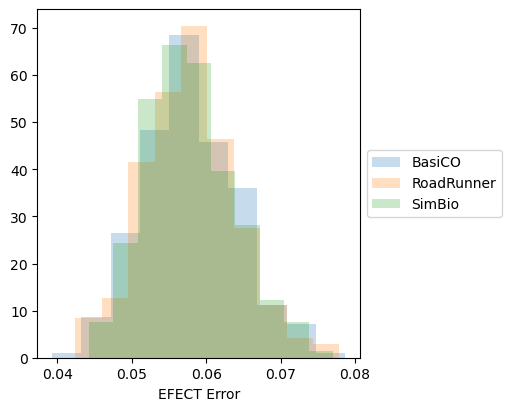

In [15]:
fig, ax = plt.subplots(1, 1, layout='compressed', figsize=(5.0, 4.0))

for sim_name, res in zip(sim_labels, err_samples):
    ax.hist(res, density=True, label=sim_name, alpha=0.25)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_xlabel('EFECT Error')

# Generate EFECT Reports

In [16]:
eval_num = 100
efect_reports: List[libssr.EFECTReport] = []

size_export = int(sample_size // 2)

for i, res in enumerate(results):

    ecf_evals = np.ndarray((num_steps, len(model_names), eval_num, 2), dtype=float)
    ecf_tval = np.ndarray((num_steps, len(model_names)), dtype=float)
    for j, name in enumerate(model_names):
        res_name = res[name]
        for k in range(num_steps):
            sample_i = res_name[:size_export, k]
            ecf_tval[k, j] = libssr.eval_final(sample_i)
            ecf_evals[k, j, :, :] = libssr.ecf(sample_i, libssr.get_eval_info_times(eval_num, ecf_tval[k, j]))

    sdata = libssr.EFECTReport.create(
        variable_names=model_names,
        simulation_times=results_times,
        sample_size=size_export,
        ecf_evals=ecf_evals,
        ecf_tval=ecf_tval,
        ecf_nval=eval_num,
        error_metric_mean=np.mean(err_samples[i]),
        error_metric_stdev=np.std(err_samples[i]),
        sig_figs=16
    )
    efect_reports.append(sdata)

# Compare Samples

In [17]:
sig_level = 0.05

efect_errors = {}
pvals = {}
efect_errors_granular = {}
pvals_granular = {}
combos_tested = []

for i in range(len(err_samples)):
    efect_errors[sim_labels[i]] = {}
    pvals[sim_labels[i]] = {}
    efect_errors_granular[sim_labels[i]] = {}
    pvals_granular[sim_labels[i]] = {}

    sdata_i = efect_reports[i]
    for j in range(len(err_samples)):
        sdata_j = efect_reports[j]
        halfdata_j = {n: v[sample_size // 2:, :] for n, v in results[j].items()}
        err = 0.0
        err_gran = {}
        pval_gran = {}
        for ni, n in enumerate(sdata_i.variable_names):
            err_gran[n] = []
            for k in range(sdata_i.simulation_times.shape[0]):
                eval_t = libssr.get_eval_info_times(sdata_i.ecf_nval, sdata_i.ecf_tval[k, ni])
                ecf_i = sdata_i.ecf_evals[k, ni, :, :]
                ecf_j = libssr.ecf(halfdata_j[n][:, k], eval_t)
                err_k = libssr.ecf_compare(ecf_i, ecf_j)
                err_gran[n].append(err_k)
                err = max(err, err_k)
            pval_gran[n] = np.asarray([libssr.pval(err_samples[i], err_k) for err_k in err_gran[n]])
        pval = libssr.pval(err_samples[i], err)

        efect_errors[sim_labels[i]][sim_labels[j]] = err
        pvals[sim_labels[i]][sim_labels[j]] = pval
        efect_errors_granular[sim_labels[i]][sim_labels[j]] = err_gran
        pvals_granular[sim_labels[i]][sim_labels[j]] = pval_gran
        combos_tested.append((sim_labels[i], sim_labels[j]))

        rejected = pval <= sig_level
        print(f'{sim_labels[i]}/{sim_labels[j]}:', 'Not Reproduced' if rejected else 'Reproduced', f'({err}, {pval})')

BasiCO/BasiCO: Reproduced (0.05202936906452326, 1.0)
BasiCO/RoadRunner: Reproduced (0.05207958993031441, 1.0)
BasiCO/SimBio: Reproduced (0.05204781015470986, 1.0)
RoadRunner/BasiCO: Reproduced (0.0519849515840036, 1.0)
RoadRunner/RoadRunner: Reproduced (0.05203519156124862, 1.0)
RoadRunner/SimBio: Reproduced (0.05200340183413802, 1.0)
SimBio/BasiCO: Reproduced (0.052005469306067344, 1.0)
SimBio/RoadRunner: Reproduced (0.05205574140867119, 1.0)
SimBio/SimBio: Reproduced (0.052023966735986096, 1.0)


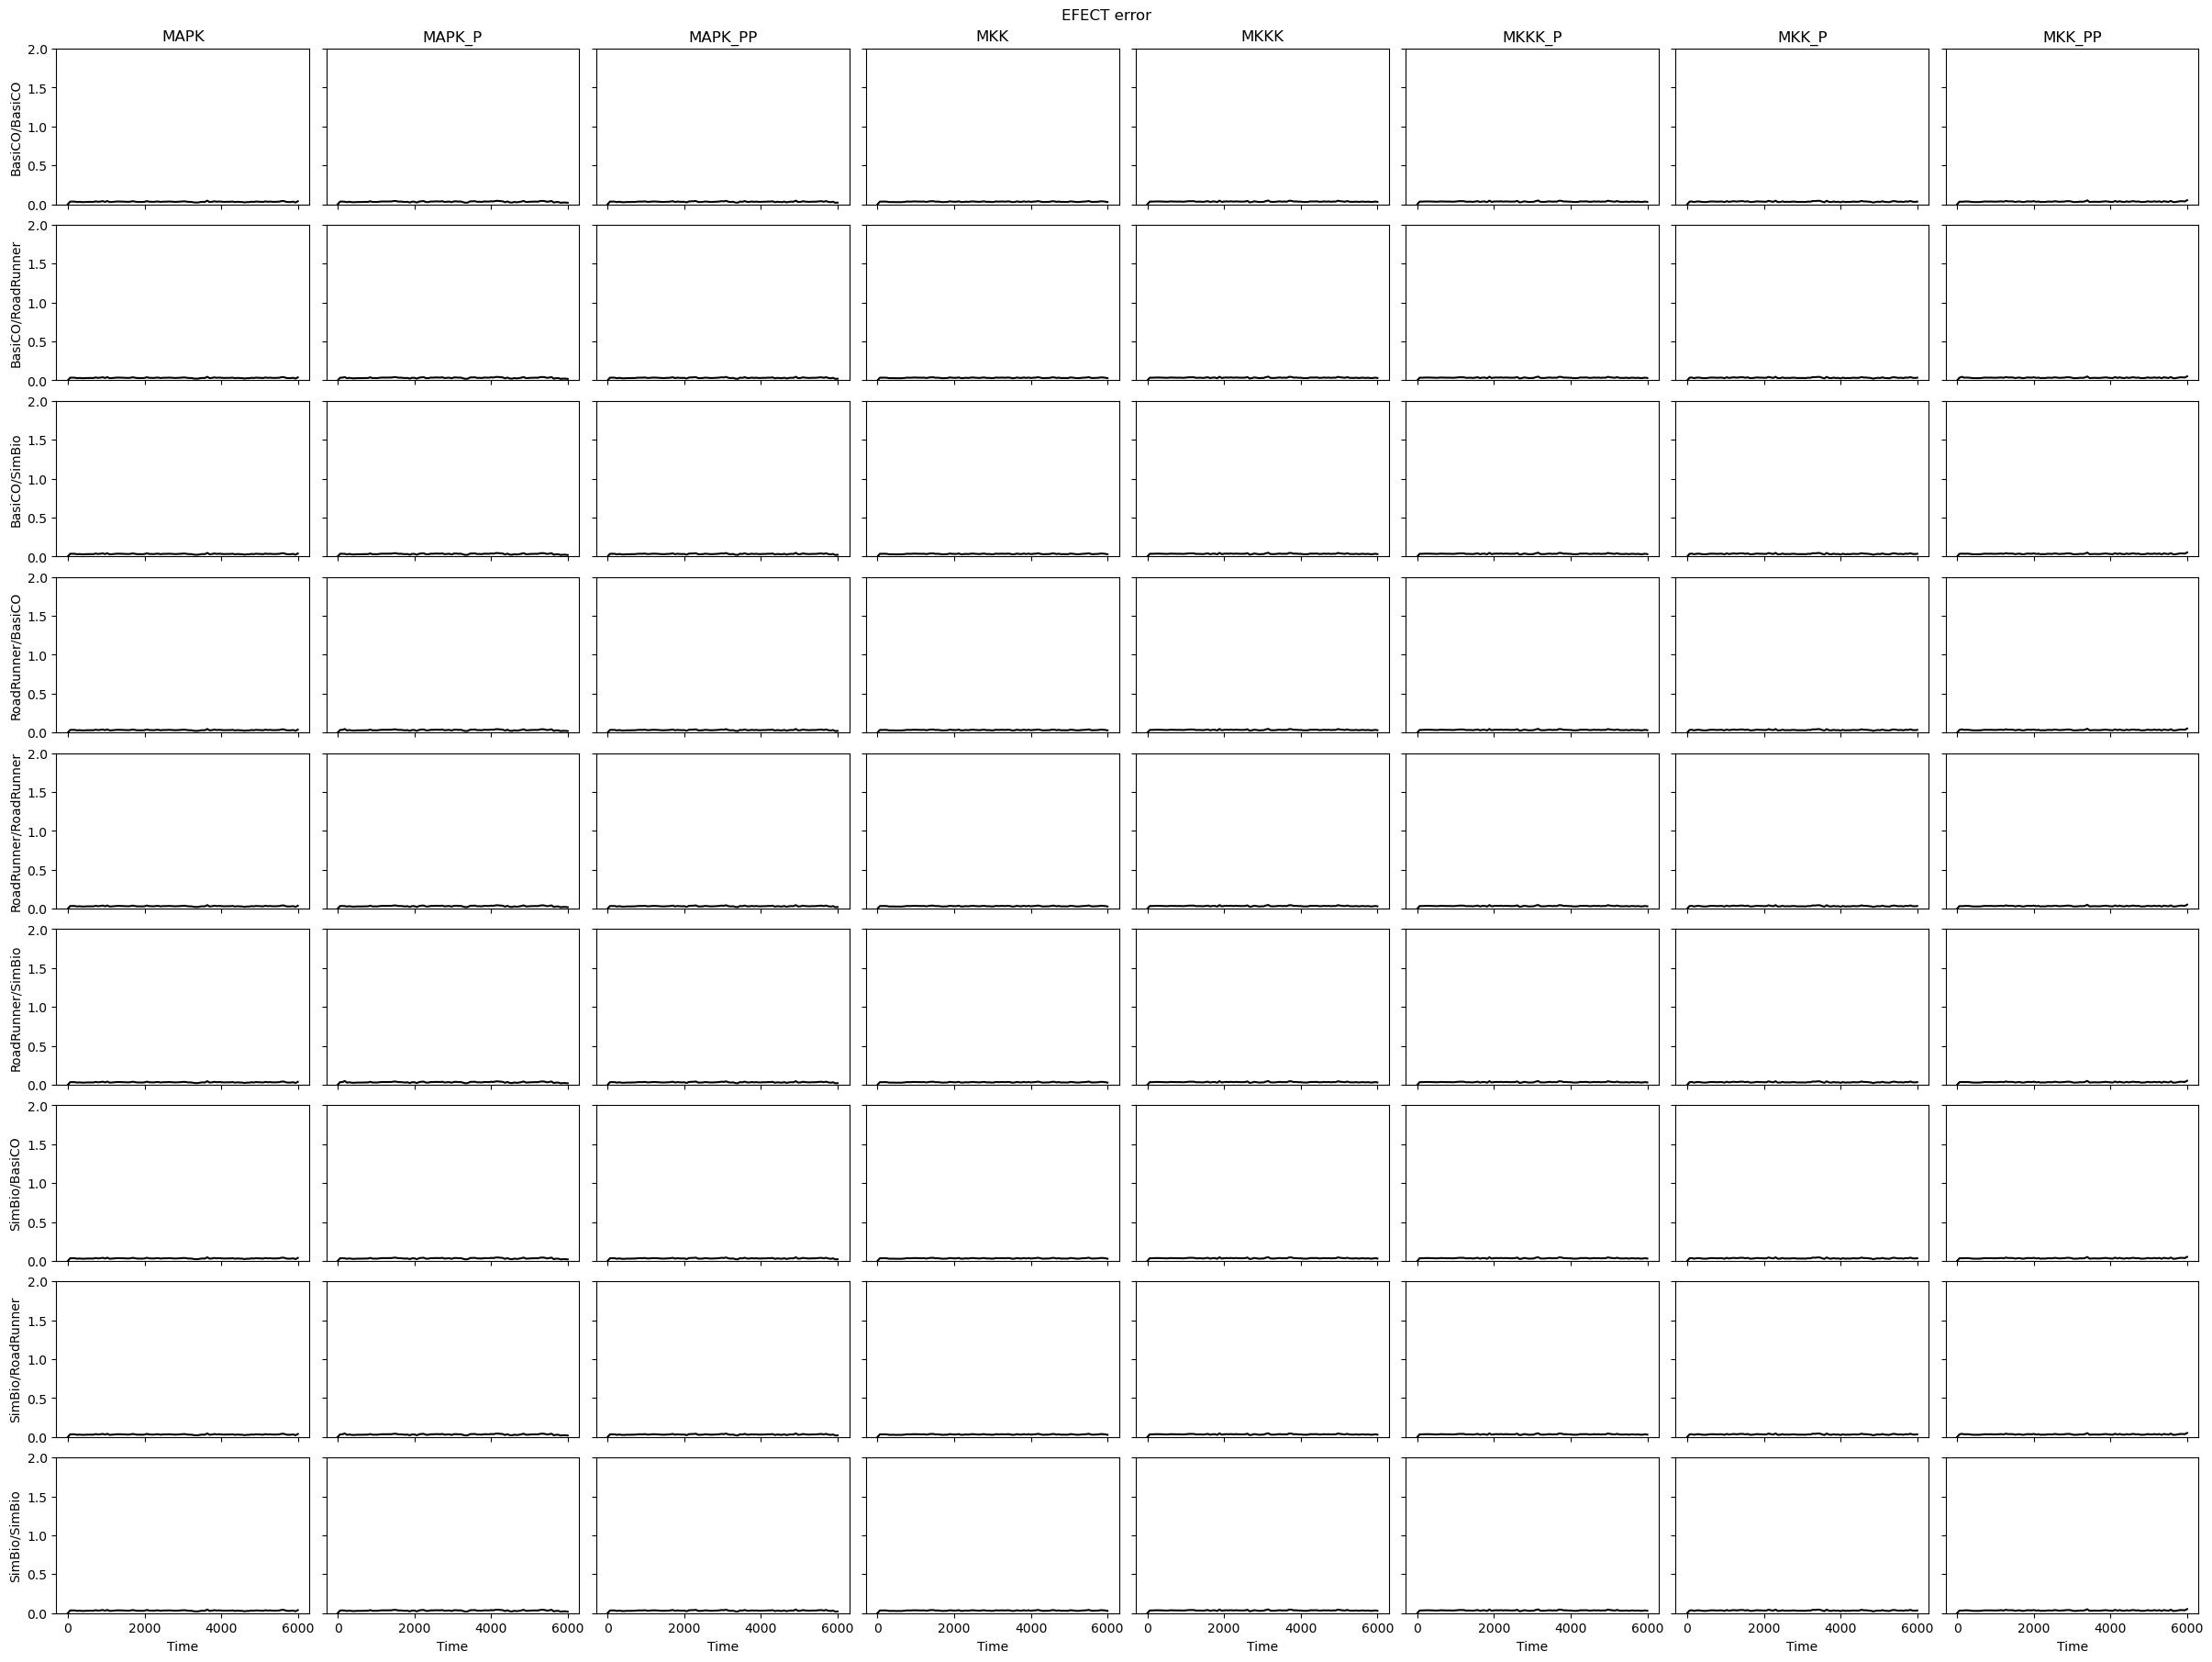

In [18]:
fig, axs = plt.subplots(len(combos_tested), len(model_names), layout='compressed', 
                        figsize=(3 * len(model_names), 2 * len(combos_tested)), sharex=True, sharey=True)
fig.suptitle('EFECT error')

for i, (si, sj) in enumerate(combos_tested):
    m = np.min(np.asarray(list(pvals_granular[si][sj].values())), axis=0) < sig_level
    for j, n in enumerate(model_names):
        axs[i][j].plot(results_times, efect_errors_granular[si][sj][n], color='black', zorder=1)
        axs[i][j].fill_between(results_times, 0, 2, where=m, alpha=0.25, color='red', zorder=0)

    axs[i][0].set_ylabel(f'{si}/{sj}')

for i in range(len(model_names)):
    axs[0][i].set_ylim(0, 2)
    axs[0][i].set_title(model_names[i])
    axs[-1][i].set_xlabel('Time')

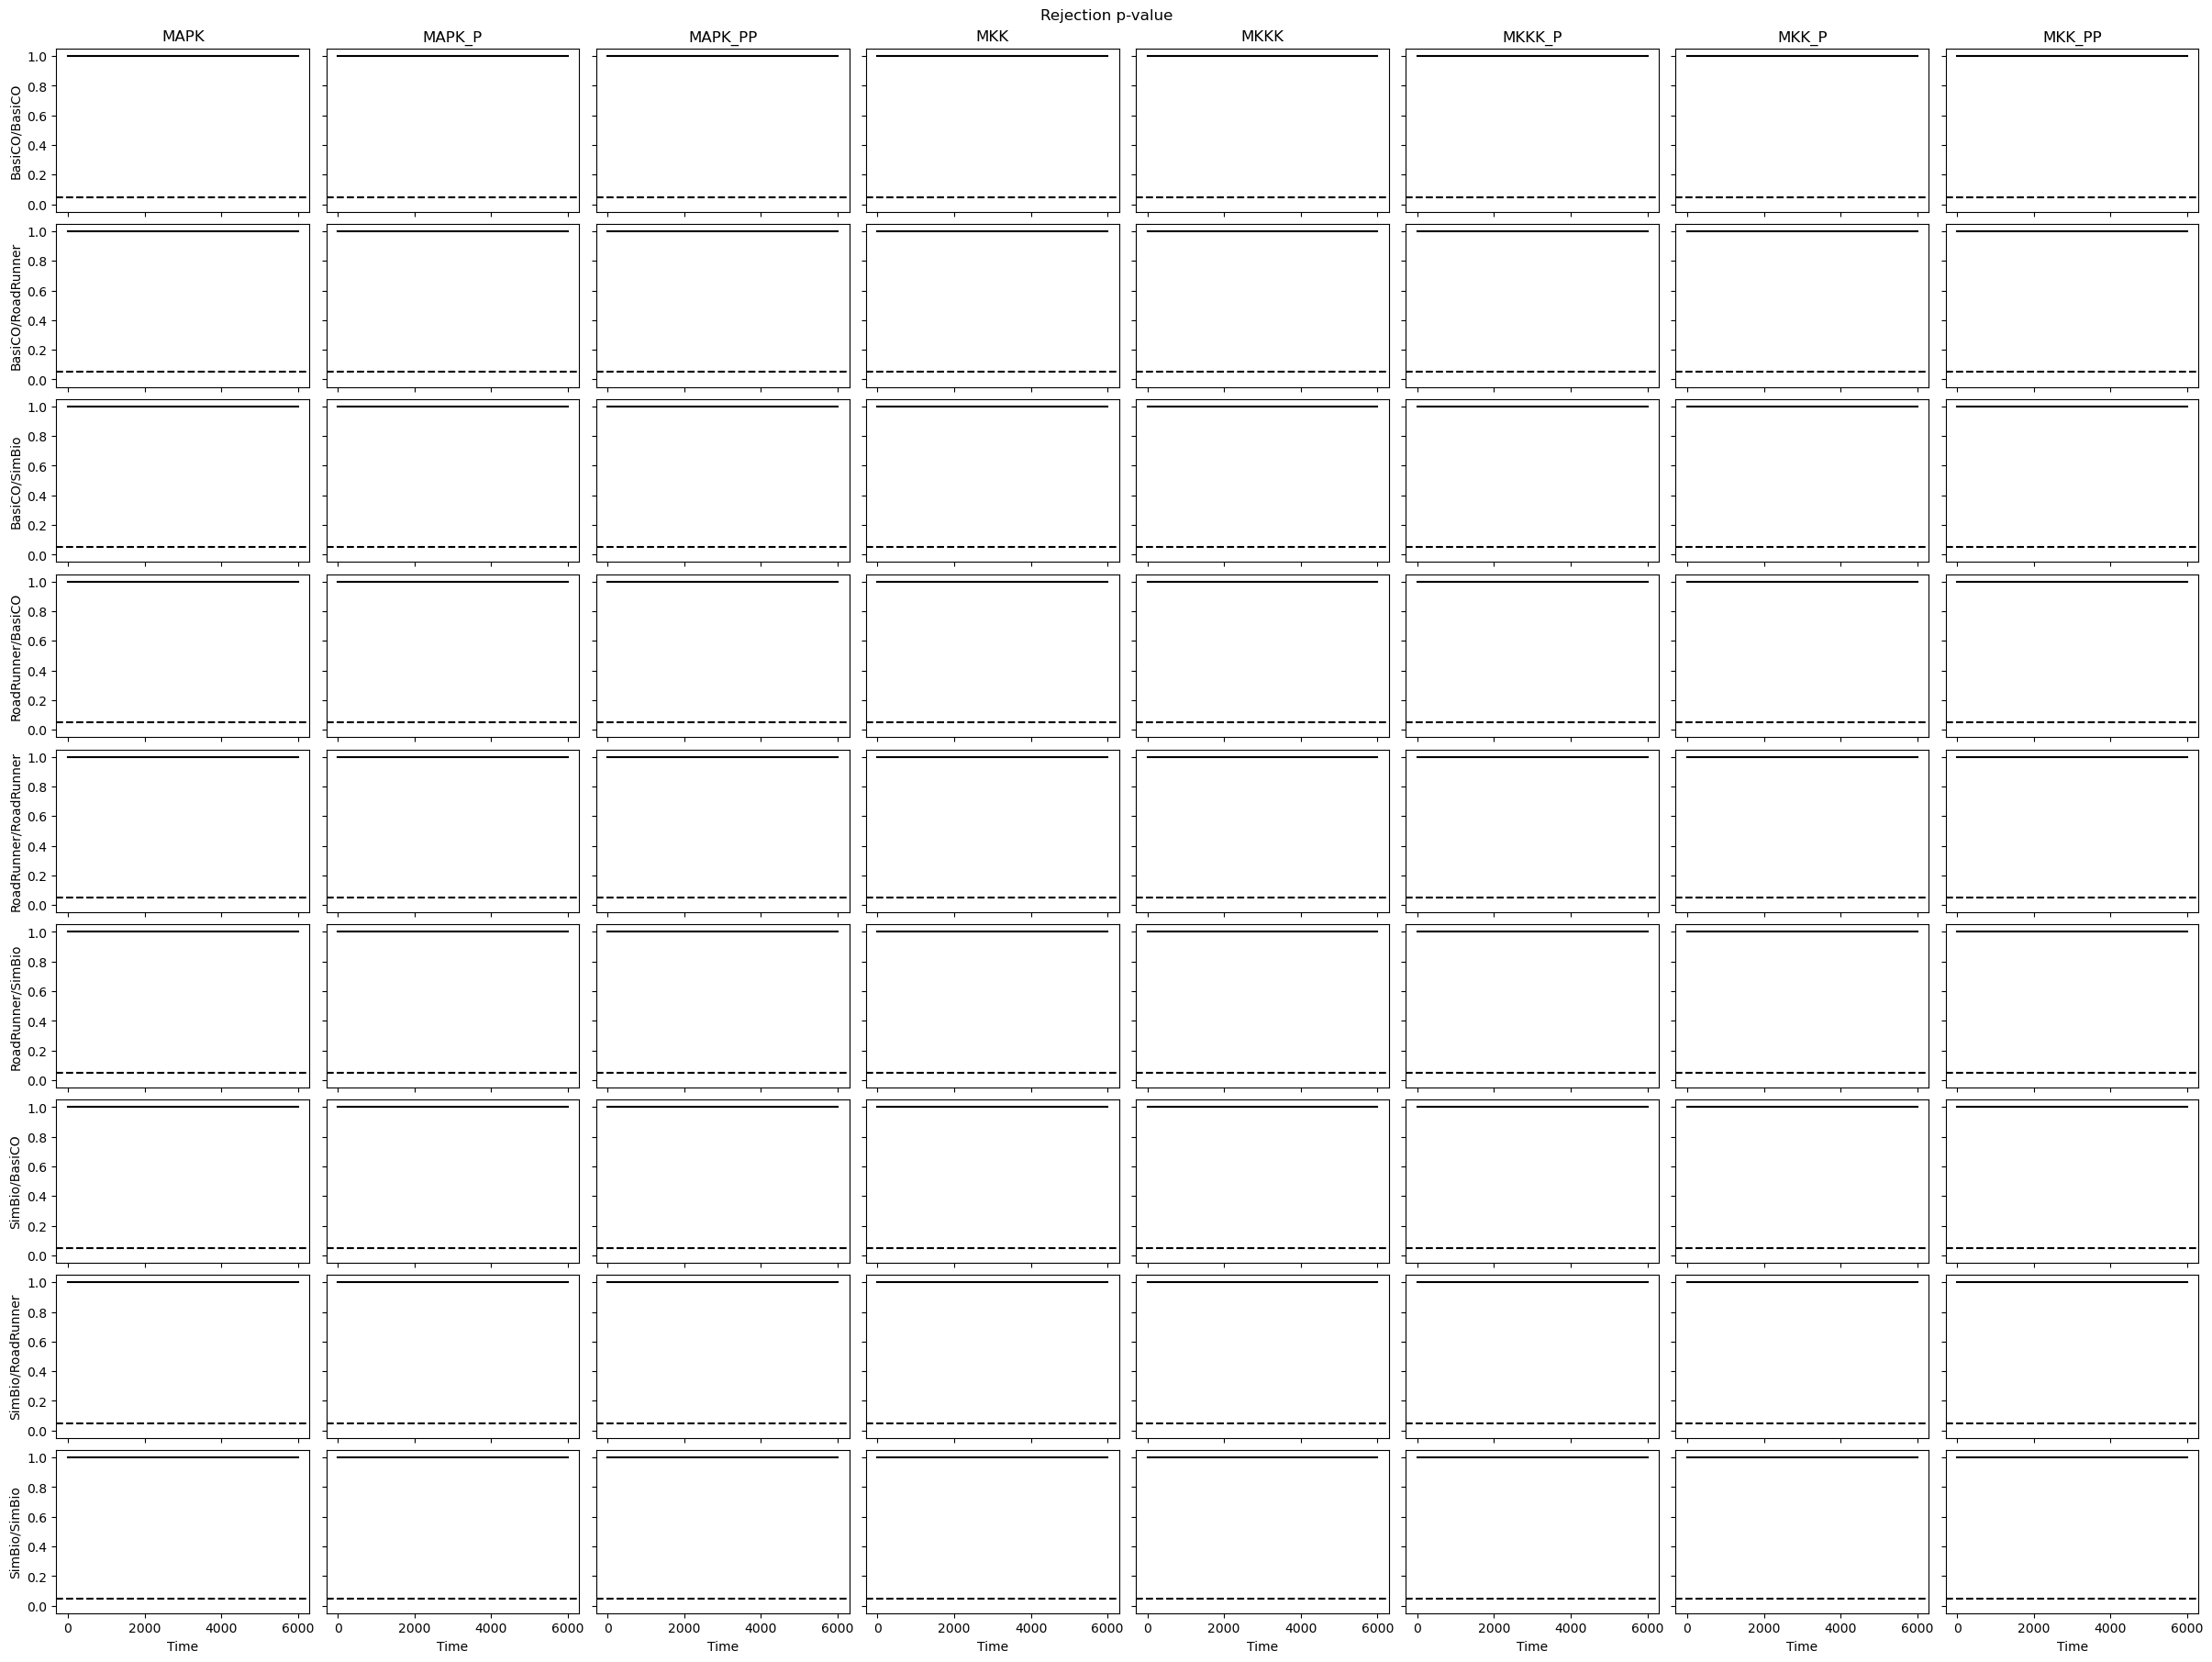

In [19]:
fig, axs = plt.subplots(len(combos_tested), len(model_names), layout='compressed', 
                        figsize=(3 * len(model_names), 2 * len(combos_tested)), sharex=True, sharey=True)
fig.suptitle('Rejection p-value')

for i, (si, sj) in enumerate(combos_tested):
    m = np.min(np.asarray(list(pvals_granular[si][sj].values())), axis=0) < sig_level
    for j, n in enumerate(model_names):
        axs[i][j].plot(results_times, pvals_granular[si][sj][n], color='black', zorder=1)
        axs[i][j].fill_between(results_times, -0.05, 1.05, where=m, alpha=0.25, color='red', zorder=0)

    axs[i][0].set_ylabel(f'{si}/{sj}')

for j in range(len(model_names)):
    axs[0][j].set_ylim(-0.05, 1.05)
    axs[0][j].set_title(model_names[j])
    axs[-1][j].set_xlabel('Time')

    for i in range(len(combos_tested)):
        axs[i][j].axhline(0.05, linestyle='--', color='black')

# Show Any Detected Differences

In [20]:
results_by_label = {lab: res for lab, res in zip(sim_labels, results)}

for i, (si, sj) in enumerate(combos_tested):
    m = np.min(np.asarray(list(pvals_granular[si][sj].values())), axis=0) < sig_level
    if np.any(m):
        indices_rejected = np.asarray(list(range(results_times.shape[0])))[np.min(np.asarray(list(pvals_granular[si][sj].values())), axis=0) < sig_level]
        first_index_rejected = indices_rejected[0]

        fig, axs = plt.subplots(1, len(model_names), layout='compressed', figsize=(3 * len(model_names), 3))
        fig.suptitle(f'First detected difference: {si} / {sj} ({results_times[first_index_rejected]:.2f} s)')
        for j, n in enumerate(model_names):
            bins = None
            for res, lab in zip(results, sim_labels):
                if lab in [si, sj]:
                    bins_res = axs[j].hist(res[n][:sample_size // 2, first_index_rejected], density=True, alpha=0.25, label=lab, bins=bins)[1]
                    if bins is None:
                        bins = bins_res

            axs[j].set_title(n)
        axs[-1].legend()